In [65]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import h5py
import time
import cooler

from scipy.ndimage.interpolation import zoom

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

# from mirnylib.numutils import zoomArray

cooler_path = '/Users/Fritz/Research/4DN/Data/hg19/Rao2014-GM12878-MboI-allreps-filtered.5kb.cool'

tads_chr22_10 = [
  ('chr22', 19015000, 19485000),
  ('chr22', 20130000, 20320000),
  ('chr22', 35705000, 36015000),
  ('chr22', 46385000, 46730000),
  ('chr22', 22800000, 22920000),
  ('chr22', 31025000, 31155000),
  ('chr22', 38795000, 38980000),
  ('chr22', 42085000, 42210000),
  ('chr22', 36535000, 36685000),
  ('chr22', 42695000, 42820000)
]

In [124]:
# Code by Hugo Brandao (hbrandao@g.harvard.edu) and Maxim Imakaev
# Adjusted by Fritz Lekschas

def averageDomains(
    domains,
    filename,
    rescaledDomainSize=30,
    minSize=100000,
    maxSize=10000000
):
    # minSize and maxSize limit what "kinds" of domains we're looking for based
    # on size exclusion
    try:
        c = cooler.Cooler(filename)
    except IOError:
        print("Could not open cooler file at {}".format(filename))
        return []
    
    resolution = c.info['bin-size']
    maps = []
    
    last_chrom = None

    for index, domain in enumerate(domains):
        chrom = domain[0]
        st = domain[1]
        nd = domain[2]
        
        futureMap = np.zeros(
            (rescaledDomainSize, rescaledDomainSize), float
        )

        if not chrom == last_chrom:
            data = c.matrix(balance=False).fetch(chrom)

        # exclude by size
        if ((nd - st) < minSize) or ((nd - st) > maxSize):
            print('Exclude domain #{} because of size constraints'.format(index))
            continue

        # exclude if too close together (sort of redundant)
        if abs(st - nd) < 10 * resolution:
            print('Exclude domain #{} because start and end is too close'.format(index))
            continue

        stBin = int(np.rint(float(st) / resolution))
        endBin = int(np.rint(float(nd) / resolution))
        mylen = endBin - stBin + 1
        
        print('#{} s:{} e:{}'.format(index, stBin, endBin))

        if stBin - mylen < 0:
            print('Exclude domain #{} because too few bins'.format(index))
            continue

        if endBin + mylen >= len(data):
            print('Exclude domain #{} because it\'s larger than the data'.format(index))
            continue

        singleMap = 1. * (
            data[
                stBin - mylen:endBin + mylen + 1,
                stBin - mylen:endBin + mylen + 1
            ]
        )

#         assert len(singleMap) % 3 == 0

        futureMap = futureMap + zoomArray(
            singleMap, futureMap.shape
        ).copy()
            
        maps.append(futureMap)
        
        last_chrom = chrom
            
    return maps


# ZOOM ARRAY from the mirnylib.numutils library #############
# URL: https://bitbucket.org/mirnylab/mirnylib

def zoomArray(inArray, finalShape, sameSum=False,
              zoomFunction=zoom, **zoomKwargs):
    """

    Normally, one can use scipy.ndimage.zoom to do array/image rescaling.
    However, scipy.ndimage.zoom does not coarsegrain images well. It basically
    takes nearest neighbor, rather than averaging all the pixels, when
    coarsegraining arrays. This increases noise. Photoshop doesn't do that, and
    performs some smart interpolation-averaging instead.

    If you were to coarsegrain an array by an integer factor, e.g. 100x100 ->
    25x25, you just need to do block-averaging, that's easy, and it reduces
    noise. But what if you want to coarsegrain 100x100 -> 30x30?

    Then my friend you are in trouble. But this function will help you. This
    function will blow up your 100x100 array to a 120x120 array using
    scipy.ndimage zoom Then it will coarsegrain a 120x120 array by
    block-averaging in 4x4 chunks.

    It will do it independently for each dimension, so if you want a 100x100
    array to become a 60x120 array, it will blow up the first and the second
    dimension to 120, and then block-average only the first dimension.

    Parameters
    ----------

    inArray: n-dimensional numpy array (1D also works)
    finalShape: resulting shape of an array
    sameSum: bool, preserve a sum of the array, rather than values.
             by default, values are preserved
    zoomFunction: by default, scipy.ndimage.zoom. You can plug your own.
    zoomKwargs:  a dict of options to pass to zoomFunction.
    """
    inArray = np.asarray(inArray, dtype=np.double)
    inShape = inArray.shape
    assert len(inShape) == len(finalShape)
    mults = []  # multipliers for the final coarsegraining
    for i in range(len(inShape)):
        if finalShape[i] < inShape[i]:
            mults.append(int(np.ceil(inShape[i] / finalShape[i])))
        else:
            mults.append(1)
    # shape to which to blow up
    tempShape = tuple([i * j for i, j in zip(finalShape, mults)])

    # stupid zoom doesn't accept the final shape. Carefully crafting the
    # multipliers to make sure that it will work.
    zoomMultipliers = np.array(tempShape) / np.array(inShape) + 0.0000001
    assert zoomMultipliers.min() >= 1

    # applying scipy.ndimage.zoom
    rescaled = zoomFunction(inArray, zoomMultipliers, **zoomKwargs)

    for ind, mult in enumerate(mults):
        if mult != 1:
            sh = list(rescaled.shape)
            assert sh[ind] % mult == 0
            newshape = sh[:ind] + [sh[ind] // mult, mult] + sh[ind + 1:]
            rescaled.shape = newshape
            rescaled = np.mean(rescaled, axis=ind + 1)
    assert rescaled.shape == finalShape

    if sameSum:
        extraSize = np.prod(finalShape) / np.prod(inShape)
        rescaled /= extraSize
    return rescaled

In [129]:
normalized_tads = averageDomains(tads_chr22_10, cooler_path, 64)
len(normalized_tads)

#0 s:3803 e:3897
#1 s:4026 e:4064
#2 s:7141 e:7203
#3 s:9277 e:9346
#4 s:4560 e:4584
#5 s:6205 e:6231
#6 s:7759 e:7796
#7 s:8417 e:8442
#8 s:7307 e:7337
#9 s:8539 e:8564


10

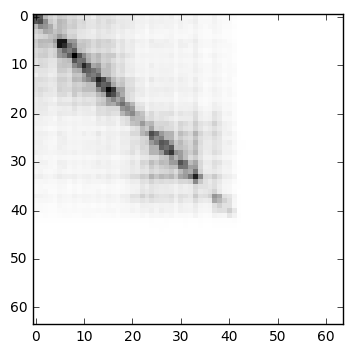

In [132]:
imshow(normalized_tads[1], 'gray_r', interpolation='none')

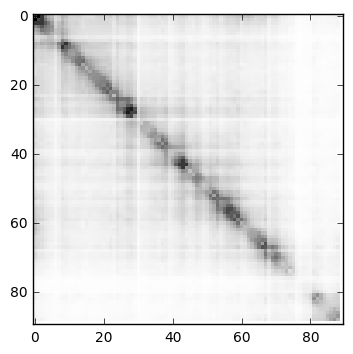

In [79]:
imshow(normalized_tads[9], 'gray_r', interpolation='none')

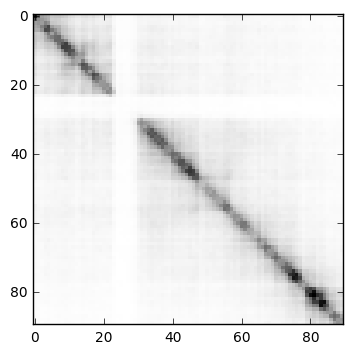

In [109]:
imshow(normalized_tads[6], 'gray_r', interpolation='none')

In [123]:
a = [
     [12, 18, 6, 3],
     [ 4,  3, 1, 2],
     [ 5,  3, 0, 2],
     [15,  8, 9, 6]
]
b = np.array(a)
b[0:4, 0:4]

array([[12, 18,  6,  3],
       [ 4,  3,  1,  2],
       [ 5,  3,  0,  2],
       [15,  8,  9,  6]])

In [107]:
a = np.array([[u'22', 17395000, 17400000, u'22', 17535000, 17540000, 0]])
np.all(a[0:,0] == a[0:,3])

True

In [119]:
a = np.array([0,2,4,6,8,10])
x = np.where(a >= 0)
x = np.where(a[x] < a.shape[0])
a[y]

array([0, 2, 4])

In [136]:
a = np.zeros((2,2), float)
a.fill(-1.0)
b = a.copy()
b

array([[-1., -1.],
       [-1., -1.]])